In [2]:
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import
from __future__ import unicode_literals  

import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.linear_model as linear_model

import scipy
import sklearn

sns.set(color_codes=True)

import tensorflow as tf
from tensorflow.contrib.learn.python.learn.datasets import base

from influence.binaryLogisticRegressionWithLBFGS import BinaryLogisticRegressionWithLBFGS
from influence.smooth_hinge import SmoothHinge
import influence.dataset as dataset
from influence.dataset import DataSet

%matplotlib inline
%load_ext autoreload
%autoreload 2

np.random.seed(42)

Using TensorFlow backend.


In [3]:
def examine_vec(x, verbose=False):
    assert len(feature_names) == len(x)
    print('Age: %s' % x[age_var_indices])
    if verbose:
        for feature_name, val in zip(feature_names, x):
            print('%32s: %.6f' % (feature_name, val))
    
def examine_train_point(idx, verbose=False):
    print('Label: %s' % Y_train[idx])
    examine_vec(modified_X_train[idx, :], verbose)
    
def examine_test_point(idx, verbose=False):
    print('Label: %s' % Y_test[idx])
    examine_vec(X_test[idx, :], verbose)

# Read and process dataset

In [4]:
df = pd.read_csv('.../data/bank-full.csv')

In [5]:
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
5,35,management,married,tertiary,no,231,yes,no,unknown,5,may,139,1,-1,0,unknown,no
6,28,management,single,tertiary,no,447,yes,yes,unknown,5,may,217,1,-1,0,unknown,no
7,42,entrepreneur,divorced,tertiary,yes,2,yes,no,unknown,5,may,380,1,-1,0,unknown,no
8,58,retired,married,primary,no,121,yes,no,unknown,5,may,50,1,-1,0,unknown,no
9,43,technician,single,secondary,no,593,yes,no,unknown,5,may,55,1,-1,0,unknown,no


In [6]:
df['y']=1*(df['y']=='yes')
df['housing']=1*(df['housing']=='yes')
df['loan']=1*(df['loan']=='yes')
df['default']=1*(df['default']=='default')

In [23]:
len(df_student)

938

In [7]:
df_student=df[df['job']=='student']
df_student.groupby(['y']).count()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
y,,,,,,,,,,,,,,,,
0,669,669,669,669,669,669,669,669,669,669,669,669,669,669,669,669
1,269,269,269,269,269,269,269,269,269,269,269,269,269,269,269,269


In [8]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,0,2143,1,0,unknown,5,may,261,1,-1,0,unknown,0
1,44,technician,single,secondary,0,29,1,0,unknown,5,may,151,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,0,2,1,1,unknown,5,may,76,1,-1,0,unknown,0
3,47,blue-collar,married,unknown,0,1506,1,0,unknown,5,may,92,1,-1,0,unknown,0
4,33,unknown,single,unknown,0,1,0,0,unknown,5,may,198,1,-1,0,unknown,0


In [9]:
X = pd.DataFrame()

X = df.loc[
    :, 
    [
        'age',
        'default',
        'balance',
        'housing',
        'loan',
        'day',
        'duration',
        'campaign',
        'pdays',
        'previous',
        'y'
        
    ]]

categorical_var_names = [
    'job',
    'marital',
    'education',
    'contact',
    'month',
    'poutcome'
]
for categorical_var_name in categorical_var_names:
    categorical_var = pd.Categorical(
        df.loc[:, categorical_var_name])
    
    # Just have one dummy variable if it's boolean
    if len(categorical_var.categories) == 2:
        drop_first = True
    else:
        drop_first = False

    dummies = pd.get_dummies(
        categorical_var, 
        prefix=categorical_var_name,
        drop_first=drop_first)
    
    X = pd.concat([X, dummies], axis=1)
    
X.drop(['y'], axis=1, inplace=True)

In [10]:
Y = np.copy(df['y'])
Y[Y == 0] = -1

feature_names = X.columns.values

df_student=df[df['job']=='student']
student_var_indices = df_student.index

In [11]:

np.random.seed(2)
num_examples = len(Y)
assert X.shape[0] == num_examples
num_train_examples = 20000
num_train_examples_pos = int(num_train_examples*0.75)
num_train_examples_neg = int(num_train_examples*0.25)
num_test_examples = num_examples - (num_train_examples_pos+num_train_examples_neg)
assert num_test_examples > 0

pos_idx = np.where(Y == -1)[0]
neg_idx = np.where(Y == 1)[0]
np.random.shuffle(pos_idx)
np.random.shuffle(neg_idx)
assert len(pos_idx) + len(neg_idx) == num_examples

train_idx = np.concatenate((pos_idx[:num_train_examples_pos], neg_idx[:num_train_examples_neg]))
test_idx = np.concatenate((pos_idx[num_train_examples_pos:], neg_idx[num_train_examples_neg:]))
np.random.shuffle(train_idx)
np.random.shuffle(test_idx)

X_train = X.iloc[train_idx, :]
Y_train = Y[train_idx]

X_test = X.iloc[test_idx, :]
Y_test = Y[test_idx]

train = DataSet(X_train, Y_train)
validation = None
test = DataSet(X_test, Y_test)
data_sets = base.Datasets(train=train, validation=validation, test=test)


In [12]:
lr_train = DataSet(X_train, np.array((Y_train + 1) / 2, dtype=int))
lr_validation = None
lr_test = DataSet(X_test, np.array((Y_test + 1) / 2, dtype=int))
lr_data_sets = base.Datasets(train=lr_train, validation=lr_validation, test=lr_test)

res_index_test=X_test.reset_index()
test_student_idx = res_index_test[res_index_test["job_student"]==1].index
index_student_train=X_train[X_train["job_student"]==1].index

In [13]:
num_classes = 2

input_dim = X_train.shape[1]
weight_decay = 0.0001
batch_size = 100
initial_learning_rate = 0.001 
keep_probs = None
decay_epochs = [1000, 10000]
max_lbfgs_iter = 1000
use_bias = True

tf.reset_default_graph()

orig_model = BinaryLogisticRegressionWithLBFGS(
    input_dim=input_dim,
    weight_decay=weight_decay,
    max_lbfgs_iter=max_lbfgs_iter,
    num_classes=num_classes, 
    batch_size=batch_size,
    data_sets=lr_data_sets,
    initial_learning_rate=initial_learning_rate,
    keep_probs=keep_probs,
    decay_epochs=decay_epochs,
    mini_batch=False,
    train_dir='output',
    log_dir='log',
    model_name='bank_logreg')

orig_model.train()

orig_model_preds = orig_model.sess.run(
    orig_model.preds,
    feed_dict=orig_model.all_test_feed_dict)
orig_model_preds = orig_model_preds[test_student_idx, 0]

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Total number of parameters: 48
Using normal model


c:\users\sabri\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\ops\gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
c:\users\sabri\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LBFGS training took [1000] iter.
After training with LBFGS: 
Train loss (w reg) on all data: 0.34739855
Train loss (w/o reg) on all data: 0.3467817
Test loss (w/o reg) on all data: 0.22289242
Train acc on all data:  0.8459
Test acc on all data:   0.9334417516163579
Norm of the mean of gradients: 0.04582937
Norm of the params: 3.5123951


In [14]:
mask_to_remove = (Y_train == -1) & (X_train.index.isin(index_student_train)) 
idx_to_remove = np.where(mask_to_remove)[0][:-1] 
mask_to_keep = np.array([True] * len(mask_to_remove), dtype=bool)
mask_to_keep[idx_to_remove] = False

modified_X_train = X_train
modified_Y_train = Y_train

modified_X_train = modified_X_train[mask_to_keep]
modified_Y_train = modified_Y_train[mask_to_keep]

n_1=np.sum(1*(X_train.index.isin(index_student_train)))
n_2=np.sum(1*(modified_X_train.index.isin(index_student_train)))

print(n_1)
print(n_2)
print('Dans les données de base, ' + str(np.sum((Y_train == 1) & (X_train.index.isin(index_student_train)))) +'/'+
                                 str(n_1)+' des étudiants étaient positifs.')
print('Dans les nouvelles données, ' + str(np.sum((modified_Y_train == 1) & (modified_X_train.index.isin(index_student_train)))) +'/'+
                                 str(n_2)+' des étudiants sont positifs.')

modified_train = DataSet(np.array(modified_X_train), np.array(modified_Y_train))
validation = None
test = DataSet(np.array(X_test), np.array(Y_test))
modified_data_sets = base.Datasets(train=modified_train, validation=validation, test=test)

lr_test = DataSet(np.array(X_test), np.array((Y_test + 1) / 2, dtype=int))
lr_modified_train = DataSet(np.array(modified_X_train), np.array((modified_Y_train + 1) / 2, dtype=int))
lr_modified_data_sets = base.Datasets(train=lr_modified_train, validation=lr_validation, test=lr_test)

502
258
Dans les données de base, 257/502 des étudiants étaient positifs.
Dans les nouvelles données, 257/258 des étudiants sont positifs.


In [15]:
tf.reset_default_graph()

modified_model = BinaryLogisticRegressionWithLBFGS(
    input_dim=input_dim,
    weight_decay=weight_decay,
    max_lbfgs_iter=max_lbfgs_iter,
    num_classes=num_classes, 
    batch_size=batch_size,
    data_sets=lr_modified_data_sets,
    initial_learning_rate=initial_learning_rate,
    keep_probs=keep_probs,
    decay_epochs=decay_epochs,
    mini_batch=False,
    train_dir='output',
    log_dir='log',
    model_name='bank_logreg')

modified_model.train()

modified_model_preds = modified_model.sess.run(
    modified_model.preds,
    feed_dict=modified_model.all_test_feed_dict)
modified_model_preds = modified_model_preds[test_student_idx, 0]
modified_theta = modified_model.sess.run(modified_model.params)[0]

Total number of parameters: 48
Using normal model


c:\users\sabri\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\ops\gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


LBFGS training took [1000] iter.
After training with LBFGS: 
Train loss (w reg) on all data: 0.34303355
Train loss (w/o reg) on all data: 0.34236464
Test loss (w/o reg) on all data: 0.23094755
Train acc on all data:  0.849311601538773
Test acc on all data:   0.9282059418507794
Norm of the mean of gradients: 0.012644699
Norm of the params: 3.6576316


c:\users\sabri\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


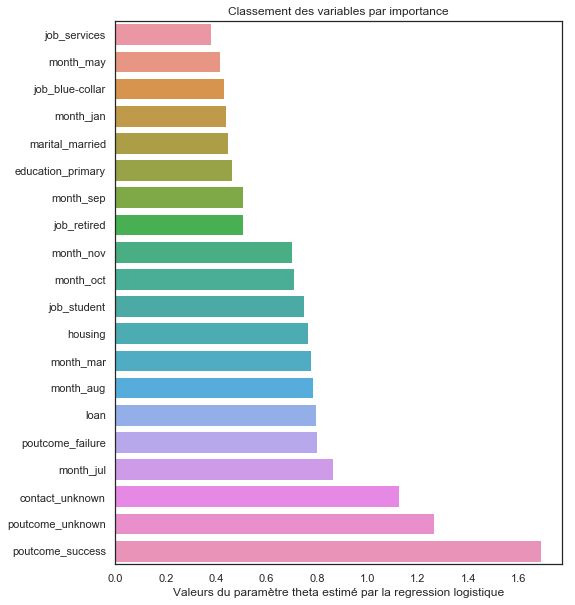

In [67]:
sns.set_style('white')
plt.figure(figsize=(8, 10))
idx = np.argsort(np.abs(modified_theta))[-20:]
g=sns.barplot(np.abs(modified_theta[idx]), X.columns.values[idx])
plt.title('Classement des variables par importance')
plt.xlabel('Valeurs du paramètre theta estimé par la regression logistique')
plt.show()

In [17]:
true_labels = Y_test[test_student_idx]

for i in range(len(test_student_idx)):
    if (orig_model_preds[i] < 0.5) != (modified_model_preds[i] < 0.5):
        print('*** ', end='')
    print("index %s, label %s: %s vs. %s" % (
        test_student_idx[i], true_labels[i], 
        orig_model_preds[i], modified_model_preds[i]))

index 29, label -1: 0.9063097 vs. 0.82409906
index 83, label -1: 0.77554053 vs. 0.6323466
*** index 97, label -1: 0.6839396 vs. 0.49779254
index 146, label -1: 0.7239436 vs. 0.55985904
*** index 215, label -1: 0.62958676 vs. 0.4556722
index 256, label -1: 0.78743196 vs. 0.6713763
*** index 383, label -1: 0.50742227 vs. 0.3328425
index 445, label -1: 0.7910762 vs. 0.66050094
index 490, label -1: 0.8111152 vs. 0.67090076
*** index 496, label -1: 0.66335875 vs. 0.4862994
index 518, label -1: 0.93171483 vs. 0.8729068
*** index 559, label -1: 0.5303287 vs. 0.3518394
index 604, label -1: 0.8713766 vs. 0.77036434
index 695, label -1: 0.9158683 vs. 0.8549163
*** index 843, label -1: 0.6356383 vs. 0.47409937
index 942, label -1: 0.8672219 vs. 0.7685615
index 971, label -1: 0.029779801 vs. 0.015716642
*** index 981, label -1: 0.53049374 vs. 0.36361176
index 1020, label -1: 0.7645514 vs. 0.6341163
*** index 1074, label -1: 0.55043846 vs. 0.39173207
index 1081, label -1: 0.3927663 vs. 0.24353713
*

In [18]:
test_idx = 29
x_test = X_test.iloc[test_idx,:]
y_test = Y_test[test_idx]
print("Test point features:")
print(x_test)
print(y_test)

influences = modified_model.get_influence_on_test_loss(
    test_indices=[29],
    train_idx=np.arange(len(modified_model.data_sets.train.labels)))

top_k = 10
helpful_points = np.argsort(influences)[-top_k:][::-1]
unhelpful_points = np.argsort(influences)[:top_k]

influences_to_plot = []
ages_to_plot = []


Test point features:
age                     23
default                  0
balance                234
housing                  1
loan                     0
day                     18
duration                33
campaign                 5
pdays                  354
previous                 7
job_admin.               0
job_blue-collar          0
job_entrepreneur         0
job_housemaid            0
job_management           0
job_retired              0
job_self-employed        0
job_services             0
job_student              1
job_technician           0
job_unemployed           0
job_unknown              0
marital_divorced         0
marital_married          0
marital_single           1
education_primary        0
education_secondary      1
education_tertiary       0
education_unknown        0
contact_cellular         1
contact_telephone        0
contact_unknown          0
month_apr                0
month_aug                0
month_dec                0
month_feb                0
month_j

In [19]:
helpful_points

array([  806, 19715,  9683,  9432,  3877, 12939, 10364, 13047,  8819,
       14784], dtype=int64)

In [20]:
modified_X_train_=modified_X_train.reset_index()
for points, message in [
    (unhelpful_points, 'worse'), (helpful_points, 'better')]:
    print("Top %s training points making the loss on the test point %s:" % (top_k, message))
    for counter, idx in enumerate(points):
        print("#%5d, class=%s, age=%s, predicted_loss_diff=%.8f" % (
            idx,                 
            modified_Y_train[idx], 
            modified_X_train_.loc[idx,'age'],
            influences[idx]))
        
        ages_to_plot.append(idx)
        influences_to_plot.append(influences[idx])

Top 10 training points making the loss on the test point worse:
#13981, class=1, age=28, predicted_loss_diff=-0.00495633
# 5662, class=1, age=20, predicted_loss_diff=-0.00380434
# 6237, class=1, age=28, predicted_loss_diff=-0.00373400
#15125, class=1, age=35, predicted_loss_diff=-0.00369584
# 1815, class=1, age=19, predicted_loss_diff=-0.00356917
#  577, class=1, age=25, predicted_loss_diff=-0.00350448
# 4471, class=1, age=25, predicted_loss_diff=-0.00347962
# 1256, class=1, age=22, predicted_loss_diff=-0.00327463
#17869, class=1, age=22, predicted_loss_diff=-0.00310562
#14586, class=1, age=29, predicted_loss_diff=-0.00304649
Top 10 training points making the loss on the test point better:
#  806, class=-1, age=40, predicted_loss_diff=0.00392929
#19715, class=-1, age=30, predicted_loss_diff=0.00239907
# 9683, class=-1, age=55, predicted_loss_diff=0.00145806
# 9432, class=-1, age=26, predicted_loss_diff=0.00143598
# 3877, class=-1, age=58, predicted_loss_diff=0.00138605
#12939, class=-1

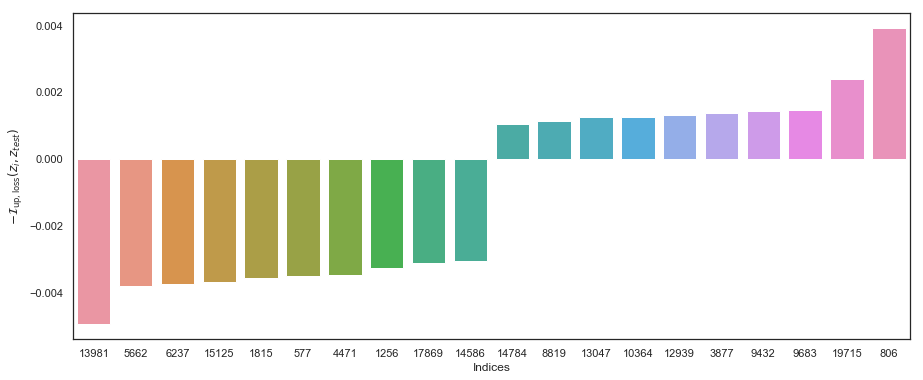

In [36]:
plt.figure(figsize=(15,6))
sort_idx = np.argsort(influences_to_plot)
ages_to_plot = np.array(ages_to_plot)
sns.barplot(ages_to_plot, influences_to_plot, order=ages_to_plot[sort_idx])
plt.xlabel('Indices')
plt.ylabel('$-\mathcal{I}_\mathrm{up, loss} (z_i , z_{test})$')
plt.show()

Norm of test gradient: 75.06151
Loaded inverse HVP from output\bank_logreg-cg-normal_loss-test-[29].npz
Inverse HVP took 0.0010027885437011719 sec


Text(0.5, 0, 'Valeurs du gradient au point $z_{test}$')

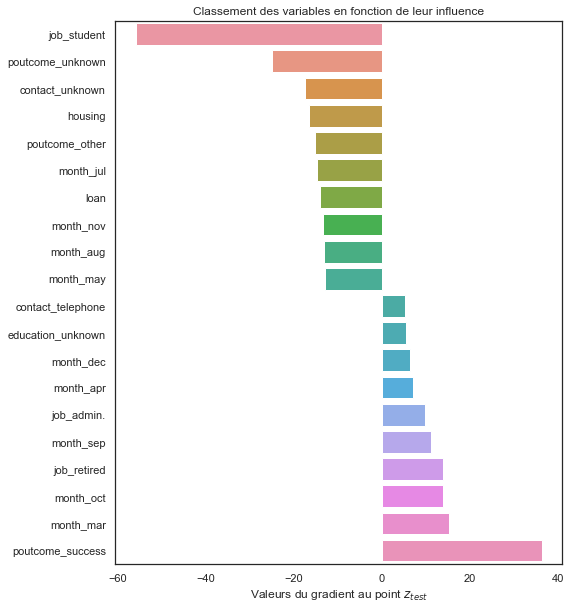

In [68]:
grad_influences_wrt_input_val = modified_model.get_grad_of_influence_wrt_input(
    [13981, 806], 
    [test_idx], 
    force_refresh=False,
    test_description=None,
    loss_type='normal_loss')    

delta = grad_influences_wrt_input_val[0, :]
plt.figure(figsize=(8, 10))
idx_to_plot = np.array([0] * len(delta), dtype=bool)
idx_to_plot[:10] = 1
idx_to_plot[-10:] = 1
g2=sns.barplot(np.sort(delta)[idx_to_plot], feature_names[np.argsort(delta)[idx_to_plot]], orient='h')
plt.title('Classement des variables en fonction de leur influence')
plt.xlabel('Valeurs du gradient au point $z_{test}$')